In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import os
import tqdm
import heapq
import datetime
import glob
import random,time

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from tensorflow.keras.utils import *
from tensorflow.keras.regularizers import * 

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
 

import pathlib
import itertools
import skvideo.io

from operator import itemgetter 

import random


import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
main_dir = 'fariza/uw-madison-gi-tract-image-segmentation'
train_folder = os.path.join(main_dir, 'train')
test_folder = os.path.join(main_dir, 'test')

In [3]:
train_df = pd.read_csv(os.path.join(main_dir, 'train.csv'))
train_df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [4]:
print(len(train_df))
print('class null values: {:.2f}%'.format(train_df['class'].isna().sum() / len(train_df) * 100))
print('segmentation null values: {:.2f}%'.format(train_df['segmentation'].isna().sum() / len(train_df) * 100))

115488
class null values: 0.00%
segmentation null values: 70.64%


In [5]:
classes = train_df.loc[:, 'class'].unique().tolist()
classes

['large_bowel', 'small_bowel', 'stomach']

In [6]:
for cl in classes:
    print('{}: {}'.format(cl, len(train_df[train_df['class'] == cl])))

large_bowel: 38496
small_bowel: 38496
stomach: 38496


In [7]:
# group train dataset by id, add 3 new columns: 'large_bowel', 'small_bowel', 'stomach'
#--------------------------------------------------------------------------------------
train_df_grouped = train_df.copy()
train_df_grouped.set_index('id', inplace = True)

seg_list = []
for cl in classes:
    seg = train_df_grouped[train_df_grouped['class'] == cl]['segmentation']
    seg.name = cl
    seg_list.append(seg)
    
train_df_grouped = pd.concat(seg_list, axis=1).reset_index()
train_df_grouped.fillna('', inplace = True)
train_df_grouped.head()

,id,large_bowel,small_bowel,stomach
0,case123_day20_slice_0001,,,
1,case123_day20_slice_0002,,,
2,case123_day20_slice_0003,,,
3,case123_day20_slice_0004,,,
4,case123_day20_slice_0005,,,


In [8]:
def get_case_day_slice(x):
    
    #--------------------------------------------------------------------------------------
    # function that parses a string (full_path or image_id)
    # and returns case, day, slice_ 
    #--------------------------------------------------------------------------------------
    
    case = re.search('case[0-9]+', x).group()[len('case'):]
    day = re.search('day[0-9]+', x).group()[len('day'):]
    slice_ = re.search('slice_[0-9]+', x).group()[len('slice_'):]
    return case, day, slice_

In [9]:
from glob import glob
import re

case_day_slice = ['case', 'day', 'slice_']

def process_df(df, path):
    
    #--------------------------------------------------------------------------------------
    # add new columns:
    # ['case', 'day', 'slice_']
    # and
    # 'full_path'
    #--------------------------------------------------------------------------------------
    
    df = df.copy()
    df.loc[:, case_day_slice] = df.id.apply(get_case_day_slice).to_list()
    
    # get list of all images 
    all_images = glob(os.path.join(path, "**", "*.png"), recursive = True)
    img_df = pd.DataFrame(all_images, columns = ['full_path'])
    img_df.loc[:, case_day_slice] = img_df.full_path.apply(get_case_day_slice).to_list()
    
    return df.merge(img_df, on = case_day_slice, how = 'left')


In [10]:
train_df_grouped = process_df(train_df_grouped, train_folder)
train_df_grouped.head()

,id,large_bowel,small_bowel,stomach,case,day,slice_,full_path
0,case123_day20_slice_0001,,,,123,20,0001,fariza/uw-madison-gi-tract-image-segmentation/...
1,case123_day20_slice_0002,,,,123,20,0002,fariza/uw-madison-gi-tract-image-segmentation/...
2,case123_day20_slice_0003,,,,123,20,0003,fariza/uw-madison-gi-tract-image-segmentation/...
3,case123_day20_slice_0004,,,,123,20,0004,fariza/uw-madison-gi-tract-image-segmentation/...
4,case123_day20_slice_0005,,,,123,20,0005,fariza/uw-madison-gi-tract-image-segmentation/...


In [11]:
train_df_grouped = train_df_grouped[(train_df_grouped['case'] != 7) | (train_df_grouped['day'] != 0)].reset_index(drop = True)
train_df_grouped = train_df_grouped[(train_df_grouped['case'] != 81) | (train_df_grouped['day'] != 30)].reset_index(drop = True)

In [12]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [13]:
# get an example of image having non-null 'large_bowel' mask
example_row = train_df_grouped[train_df_grouped['large_bowel'] != ''].iloc[0, :]
example_row

id                                      case123_day20_slice_0075
large_bowel    23058 4 23323 6 23588 8 23854 9 24119 10 24385...
small_bowel                                                     
stomach        12388 11 12652 14 12916 18 13180 22 13445 24 1...
case                                                         123
day                                                           20
slice_                                                      0075
full_path      fariza/uw-madison-gi-tract-image-segmentation/...
Name: 74, dtype: object

In [14]:
img_path = example_row.full_path
img_path

'fariza/uw-madison-gi-tract-image-segmentation/train/case123/case123_day20/scans/slice_0075_266_266_1.50_1.50.png'

In [15]:
import matplotlib.pyplot as plt

def print_img_info(img):
    img_arr = np.asarray(img)
    print(img_arr.shape)
    print(img_arr[100])
    plt.imshow(img)

(266, 266)
[0.         0.         0.         0.         0.         0.
 0.00666819 0.00637827 0.00579843 0.00724804 0.00782788 0.00492866
 0.00492866 0.00608835 0.00521859 0.02348363 0.05740444 0.07016098
 0.07364004 0.04696727 0.02319371 0.01565576 0.01188678 0.0162356
 0.02580301 0.03479057 0.05073625 0.05624475 0.04841688 0.03044175
 0.01275654 0.03102159 0.03739986 0.03392081 0.02899214 0.03421073
 0.03826963 0.03102159 0.03768978 0.04000916 0.03421073 0.03392081
 0.03392081 0.0365301  0.04029908 0.03768978 0.03682002 0.03566033
 0.03595025 0.03624018 0.03566033 0.03508049 0.03566033 0.03421073
 0.03044175 0.03073167 0.03479057 0.04261845 0.04116884 0.03566033
 0.03450065 0.03913939 0.04493782 0.040589   0.03537041 0.03595025
 0.03797971 0.04000916 0.04000916 0.04116884 0.03797971 0.04000916
 0.03739986 0.03942931 0.04377813 0.03826963 0.03508049 0.03855955
 0.04290837 0.03971924 0.04348821 0.04319829 0.03913939 0.03884947
 0.03739986 0.03305104 0.03739986 0.04522774 0.040589   0.03

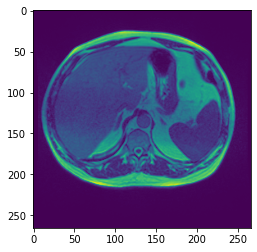

In [16]:
import matplotlib.image as mpimg
print_img_info(mpimg.imread(img_path, format = 'png'))

(266, 266)
[   0.    0.    0.    0.    0.    0.  437.  418.  380.  475.  513.  323.
  323.  399.  342. 1539. 3762. 4598. 4826. 3078. 1520. 1026.  779. 1064.
 1691. 2280. 3325. 3686. 3173. 1995.  836. 2033. 2451. 2223. 1900. 2242.
 2508. 2033. 2470. 2622. 2242. 2223. 2223. 2394. 2641. 2470. 2413. 2337.
 2356. 2375. 2337. 2299. 2337. 2242. 1995. 2014. 2280. 2793. 2698. 2337.
 2261. 2565. 2945. 2660. 2318. 2356. 2489. 2622. 2622. 2698. 2489. 2622.
 2451. 2584. 2869. 2508. 2299. 2527. 2812. 2603. 2850. 2831. 2565. 2546.
 2451. 2166. 2451. 2964. 2660. 2413. 2755. 2717. 2736. 2527. 2413. 2584.
 2527. 2622. 2622. 2603. 2603. 2489. 2508. 2660. 2679. 2280. 2394. 2318.
 2451. 2679. 2508. 2622. 2394. 2356. 2261. 1976. 2033. 2565. 2641. 2603.
 2565. 2546. 2660. 2622. 2717. 2470. 2204. 2660. 2660. 2736. 3078. 3667.
 4294. 4256. 4807. 5263. 5434. 5453. 4807. 3876. 3800. 3648. 4218. 5187.
 5567. 6175. 5681. 5263. 4959. 3534. 1881. 1577. 1843. 2261. 3192. 4541.
 5738. 5149. 3097. 1482. 1539. 2850. 383

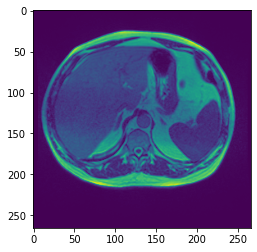

In [17]:
img = tf.keras.preprocessing.image.load_img(img_path, color_mode = "grayscale")
img = tf.keras.preprocessing.image.img_to_array(img)
print_img_info(img[:, :, 0])

In [18]:
mask_seq = example_row.large_bowel

(266, 266, 1)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]


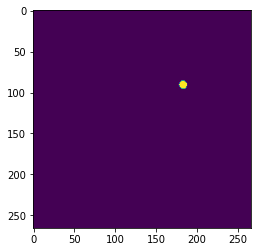

In [19]:
mask = rle_decode(mask_seq, img.shape)
print(mask.shape)
print(mask[90, :, 0])
plt.imshow(mask)

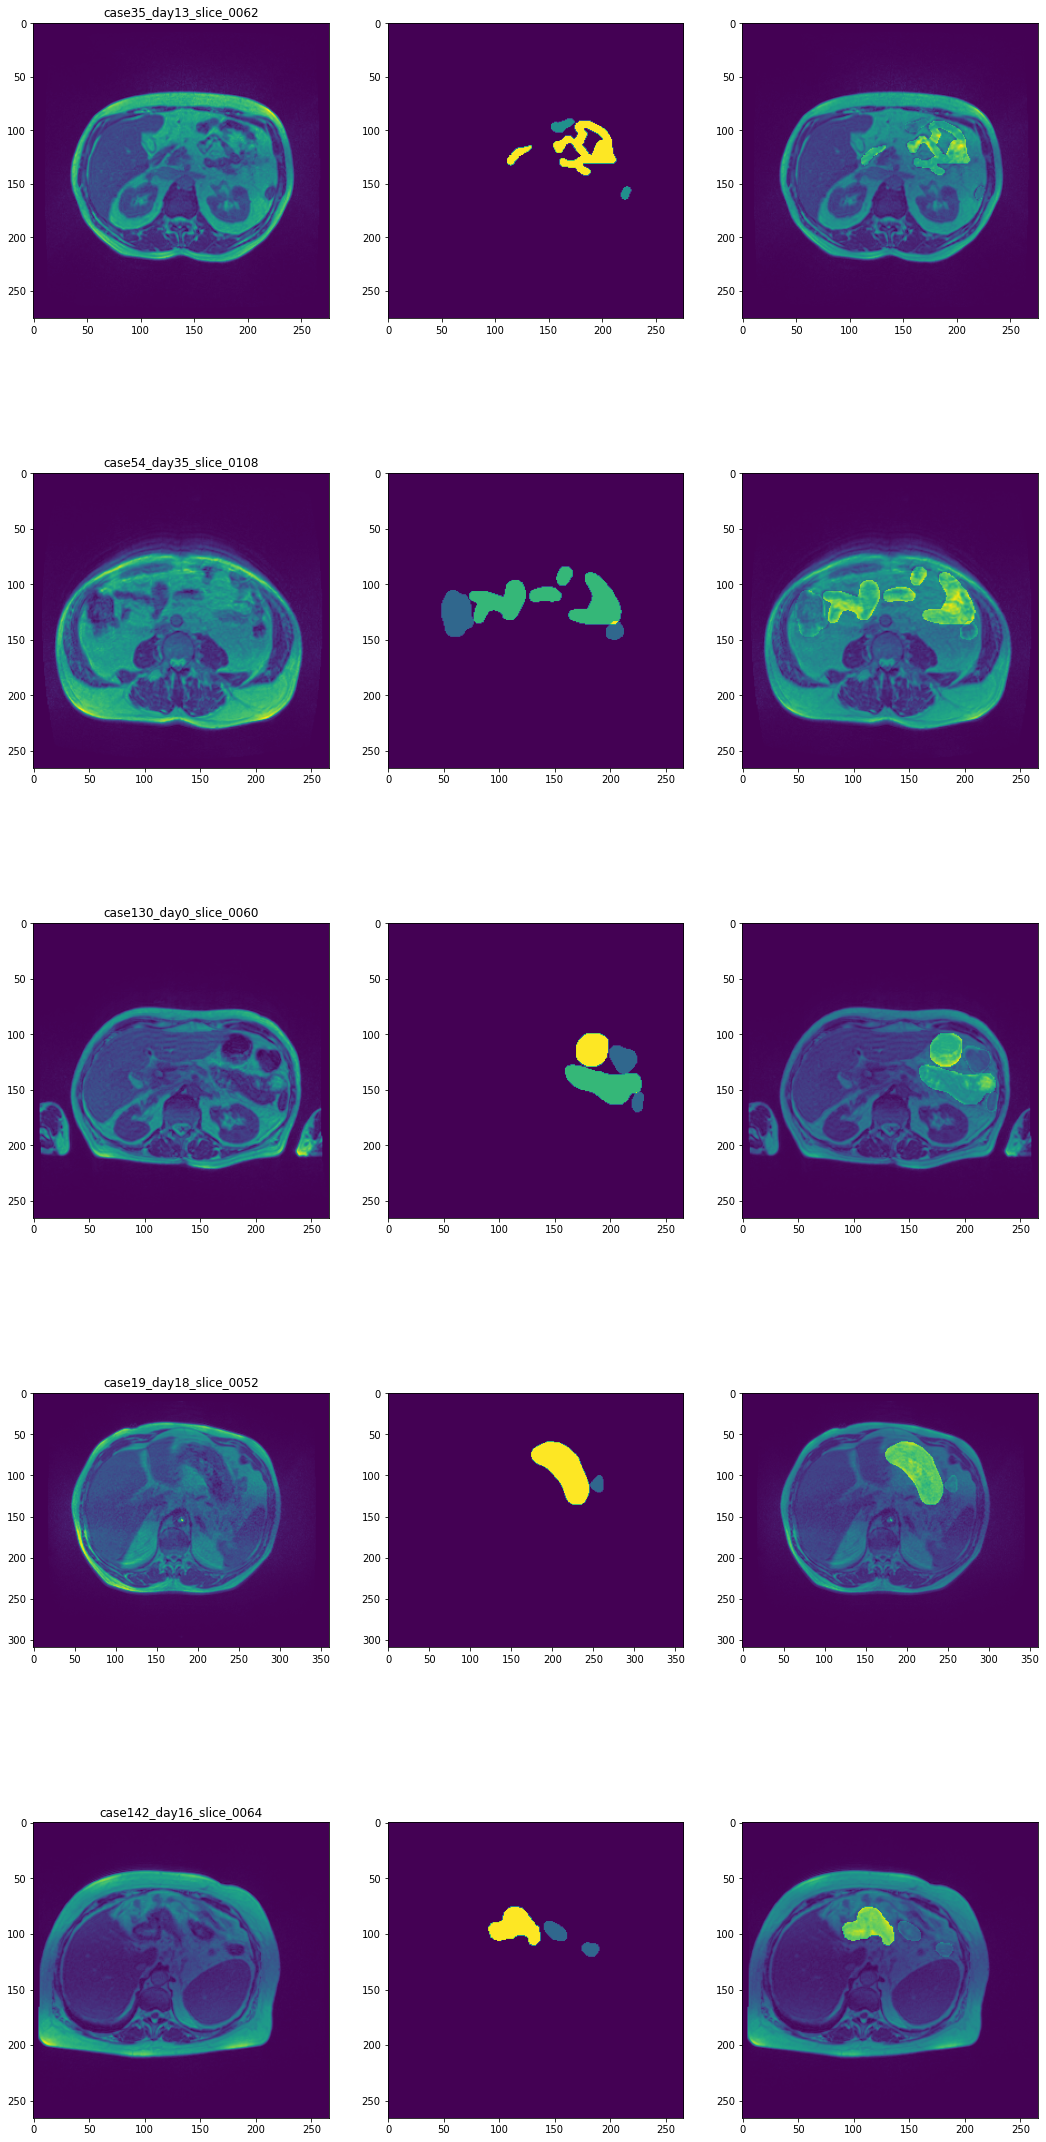

In [20]:
num = 5
segmentation_df_example = train_df_grouped[train_df_grouped.large_bowel != ''].sample(num)

fig, ax = plt.subplots(num, 3, figsize=(18, 8*num))
for i in range(num):
    record = segmentation_df_example.iloc[i, :]
    
    img = mpimg.imread(record.full_path, format = 'png')
    ax[i, 0].imshow(img)
    ax[i, 0].set_title(record.id)
    
    mask = np.zeros(img.shape)
    for j, cl in enumerate(classes):
        mask += rle_decode(record[cl], img.shape)*(j + 1) / 4 * np.max(img)
    ax[i, 1].imshow(mask)
    
    ax[i, 2].imshow(img + mask)

In [21]:
from enum import Enum, auto

class GeneratorMode(Enum):
    TRAIN = auto()
    TEST = auto()

In [22]:
img_size = 160

class ImageDataGen(tf.keras.utils.Sequence):
    
    def __init__(self,
                 df,
                 batch_size,
                 mode = GeneratorMode.TRAIN):

        self.df = df
        self.batch_size = batch_size
        self.image_size = img_size
        self.mode = mode
        
        self.len = len(df)
        
    def __getitem__(self, index):
        
        start, end = index * self.batch_size, (index + 1) * self.batch_size
        
        images = np.zeros((self.batch_size, self.image_size, self.image_size, 1))
        masks = np.zeros((self.batch_size, self.image_size, self.image_size, len(classes)))
        for i , pos in enumerate(range(start, end)):
            row = self.df.iloc[pos, :]
            
            #image
            image = tf.keras.preprocessing.image.load_img(row['full_path'], color_mode = "grayscale")
            image = tf.keras.preprocessing.image.img_to_array(image)
            image_shape = image.shape
            
            image = tf.image.resize(image, (self.image_size, self.image_size), method = 'nearest').numpy()
            image = image.reshape((self.image_size, self.image_size))
            images[i, :, :, 0] = image / np.max(image)
            
            # masks (only train/val mode)
            if self.mode == GeneratorMode.TRAIN:
                for j, cl in enumerate(classes):
                    feat = row[cl]
                    mask = rle_decode(feat, image_shape)
                    mask = tf.image.resize(mask, (self.image_size, self.image_size), method = 'nearest').numpy()
                    mask = mask.reshape((self.image_size, self.image_size))
                    masks[i, :, :, j] = mask
              
        return (images, masks) if self.mode == GeneratorMode.TRAIN else images
                
    
    def __len__(self):
        return self.len // self.batch_size

In [23]:
from sklearn.model_selection import train_test_split
train_set, val_set = train_test_split(train_df_grouped, test_size = 0.1, shuffle = True, random_state = 42)

In [24]:
train_data_gen = ImageDataGen(train_set, 64)
val_data_gen = ImageDataGen(val_set, 64)

In [25]:
from tensorflow.keras import layers

In [26]:
filters=256
depth=4
kernel_size=5
patch_size=2

In [27]:
def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

def downsample_blocko(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p


def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

def downsample_block(x, n_filters):
    f = patch_mix(x, n_filters, patch_size,depth, kernel_size) 
    p = layers.Dropout(0.3)(f)
    f =   UpSampling2D(size=(2, 2)) (p)
    return f, p




def preproc(x):
    x1 = Conv2D(1, 3, padding = "same", activation = "gelu")(x)
    x2 = Conv2D(1, 5, padding = "same", activation = "gelu")(x)
    x3 = Conv2D(1, 7, padding = "same", activation = "gelu")(x)
    #x4 = Conv2D(1, 5, padding = "same", activation = "gelu")(x)
    s1 = Subtract()([x2,x1])
    s2 = Subtract()([x3,x2])
    
    conc = Concatenate()([x,s1,s2])
    
    
    
    return conc
 

In [28]:
fb = 1

def build_unet_model():
    inputs = layers.Input(shape=(img_size, img_size, 1))
    
    inputso = preproc(inputs)
    
    f1, p1 = downsample_blocko(inputso, 64//fb)
    f2, p2 = downsample_blocko(p1, 128//fb)
    f3, p3 = downsample_blocko(p2, 256//fb)
    f4, p4 = downsample_blocko(p3, 512//fb)
    
    bottleneck = double_conv_block(p4, 1024//fb)
    
    u6 = upsample_block(bottleneck, f4, 512//fb)
    u7 = upsample_block(u6, f3, 256//fb)
    u8 = upsample_block(u7, f2, 128//fb)
    u9 = upsample_block(u8, f1, 64//fb)
    
    outputs = layers.Conv2D(len(classes), 1, padding="same", activation = "sigmoid")(u9)
    
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    
    return unet_model

In [29]:
from keras import backend as K

kld = tf.keras.losses.KLDivergence()

# addind a 'smooth' value which equals to 1 just to avoid dividing by 0 in case y_true and y_pred consist of 0
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

#intersection over union coefficient
def iou_coef(y_true, y_pred, smooth = 1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [30]:
from tensorflow.keras.losses import BinaryCrossentropy

def loss_f(y_true, y_pred):
    bce = BinaryCrossentropy()
    return dice_loss(y_true, y_pred) + bce(y_true, y_pred) 

def loss_e(y_true, y_pred):
    bce = BinaryCrossentropy()
    return dice_loss(y_true, y_pred)  + kld(y_true, y_pred)
    
def dice_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

In [31]:
def activation_block(x):
    x = Activation("gelu")(x)
    return LayerNormalization()(x)


def conv_stem(x, filters: int, patch_size: int):
    x = Conv2D(filters, kernel_size=patch_size,padding='same', strides=patch_size)(x)
    return activation_block(x)


def conv_mixer_block(x, filters: int, kernel_size: int):
    # Depthwise convolution.
    x0 = x
    x = DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x)
    x = Add()([activation_block(x), x0])  # Residual.

    # Pointwise convolution.
    x = Conv2D(filters, kernel_size=1)(x)
    x = activation_block(x)

    return x



def patch_mix(inputs, filters, patch_size,depth, kernel_size):
    x = conv_stem(inputs, filters, patch_size)

    # ConvMixer blocks.
    for _ in range(depth):
         x = conv_mixer_block(x, filters, kernel_size)
    return x

In [32]:
def vector_block(xyz,cmf, red):
    # red means reduction 
    # cmf means filters, denotes vector size
    x = xyz
    opt1 = conv_stem(x,cmf,red)
    opt2 = conv_stem(x,cmf,red)
    opt3 = conv_stem(x,cmf,red)
    opt4 = conv_stem(x,cmf,red)


    o1 = tf.reduce_mean(opt1,[2,1])
    o2 = tf.reduce_mean(opt2,[2,1])
    o3 = tf.reduce_mean(opt3,[2,1])
    o4 = tf.reduce_mean(opt4,[2,1])
    o5 = concatenate([o1,o2,o3,o4],-1)
    return o5

def mlp_feature(vect,cmf):
    
 
    oo = Flatten()(vect) 
    o6 =  Dense(cmf*2, activation='gelu')(oo)
    o6 =  Dropout(0.2)(o6)
    o6 =  Dense(cmf*4, activation='gelu')(o6)

    o6= Reshape((1, cmf*4))(o6)
    o7 =  K.permute_dimensions(o6, (0,2,1))
    
    o8 = multiply([o6,o7])
    o8 =tf.expand_dims(o8,-1)
    o8 =   MaxPool2D(4)(o8 )
    
    
    return o8


def regu(xyz, filt):
    x = Conv2D(filt,(3,3), activation='gelu', padding="same")(xyz) 
    x =   MaxPool2D(2)(x)
    return x


def frz_block(xyz):
    [a1,a2,a3,a4] =xyz.get_shape()
    cmf = a2
    o5 = vector_block(xyz,cmf, 5)
    o7 = mlp_feature(o5,cmf) 

    o7 = concatenate([o7,xyz,o7],-1)
    return o7


def frz_blocke(xyz):
    [a1,a2,a3,a4] =xyz.get_shape()
    cmf = a2
    o5 = vector_block(xyz,cmf, 5)
    o7 = mlp_feature(o5,cmf) 
 
    return o7

def up_frz(x1,x2, n_filters):
    x1 = Conv2DTranspose(n_filters*4, 3, 2, activation='gelu', padding="same")(x1)
    x2 = Conv2D(n_filters*2, 3, activation='gelu', padding="same")(x2)
    x =  concatenate([x1, x2])
    x =  Dropout(0.3)(x)
    return x

In [33]:
inputs = layers.Input(shape=(img_size, img_size, 1))

g_filter = 32
u_filter = 8

o1 = frz_block( regu((inputs),g_filter)) #80

o2 =  frz_block(regu(o1,g_filter*2))  #40

o3 =  frz_block(regu(o2,g_filter*4))  #20

o4 =  frz_block(regu(o3,g_filter*8))  #10

o5 =  frz_block(regu(o4,g_filter*16))  #5
 
## -------------------------------------- ##    
    
    
u1 =  up_frz(o5,o4,u_filter*16)  # 10 

cu1 =  concatenate([u1, o4]) # 10 


u2 =  up_frz(cu1,o3,u_filter*8) # 20 

cu2 =  concatenate([u2, o3]) # 20 

u3 =  up_frz(cu2,o2,u_filter*4) # 40 


cu3 =  concatenate([u3, o2])  # 40 

u4 =  up_frz(cu3,o1,u_filter*2) # 40 

cu4 =  concatenate([u4, o1])  # 40 


ex_u = UpSampling2D(2)(o1)

u5 =  up_frz(cu4,ex_u,u_filter) # 40 

## -------------------------------------- ##  


seg_map = Conv2D(3 , 3, activation='sigmoid', padding="same")(u5) 


frz_seg_model = Model(inputs, seg_map)

# frz_model.summary()

2023-02-26 00:48:17.696797: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-26 00:48:17.718100: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-26 00:48:17.718215: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-26 00:48:17.718604: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [34]:
def cab(input_tensor,channels):
    channels = list(input_tensor.shape)[-1]
    average_pooling =  GlobalAveragePooling2D()(input_tensor)
    
    feature_descriptor = tf.reshape(average_pooling, shape=(-1, 1, 1, channels))
    
    feature_activations =  Conv2D(filters=channels // 8, kernel_size=(1, 1), activation="relu")(feature_descriptor)
    
    feature_activations = Conv2D(filters=channels, kernel_size=(1, 1), activation="sigmoid")(feature_activations)
    return input_tensor * feature_activations



def sab(input_tensor):
    average_pooling = tf.reduce_max(input_tensor, axis=-1)
    average_pooling = tf.expand_dims(average_pooling, axis=-1)
    max_pooling = tf.reduce_mean(input_tensor, axis=-1)
    max_pooling = tf.expand_dims(max_pooling, axis=-1)
    concatenated = Concatenate(axis=-1)([average_pooling, max_pooling])
    feature_map = Conv2D(1, kernel_size=(1, 1))(concatenated)
    feature_map = tf.nn.sigmoid(feature_map)
    return input_tensor * feature_map



def daub(input_tensor,channels):
    channels = list(input_tensor.shape)[-1]
    feature_map = Conv2D(channels, kernel_size=(3, 3), padding="same", activation="relu")(input_tensor)
    feature_map = Conv2D(channels, kernel_size=(3, 3), padding="same")(feature_map)
    channel_attention = cab(feature_map, channels)
    spatial_attention = sab(feature_map)
    concatenation = Concatenate(axis=-1)([channel_attention, spatial_attention])
    concatenation = Conv2D(channels, kernel_size=(1, 1))(concatenation)
    return Add()([input_tensor, concatenation])




def vector_blocke(xyz,cmf):
    # red means reduction 
    # cmf means filters, denotes vector size
    x = xyz
    opt1 = conv_stem(x,cmf,1)
    opt2 = conv_stem(x,cmf,3)
    opt3 = conv_stem(x,cmf,5)
    opt4 = conv_stem(x,cmf,7)


    o1 = tf.reduce_mean(opt1,[2,1])
    o2 = tf.reduce_mean(opt2,[2,1])
    o3 = tf.reduce_mean(opt3,[2,1])
    o4 = tf.reduce_mean(opt4,[2,1])
    o5 = concatenate([o1,o2,o3,o4],-1)
    o5 = Dense(cmf, activation='gelu')(o5)
    o5 = tf.reshape(o5, shape=(-1, 1, 1, cmf))
    fe =  Conv2D(cmf // 8, kernel_size=(1, 1), padding='same',  activation="relu")(o5)
    
    fa = Conv2D(cmf, kernel_size=(1, 1), padding='same',activation="sigmoid")(fe)
    
    
    return fa*xyz

In [35]:
inputs = layers.Input(shape=(img_size, img_size, 1))

g_filter = 32
u_filter = 8

o1 = frz_block( regu((inputs),g_filter)) #80

o2 =  frz_block(regu(o1,g_filter*2))  #40

o3 =  frz_block(regu(o2,g_filter*4))  #20

o4 =  frz_block(regu(o3,g_filter*8))  #10

o5 =  frz_block(regu(o4,g_filter*16))  #5
 
## -------------------------------------- ##    
    
    
u1 =  up_frz(o5,o4,u_filter*16)  # 10 

cu1 =  concatenate([u1, o4]) # 10 


u2 =  up_frz(cu1,o3,u_filter*8) # 20 

cu2 =  concatenate([u2, o3]) # 20 

u3 =  up_frz(cu2,o2,u_filter*4) # 40 


cu3 =  concatenate([u3, o2])  # 40 

u4 =  up_frz(cu3,o1,u_filter*2) # 40 

cu4 =  concatenate([u4, o1])  # 40 


ex_u = UpSampling2D(2)(o1)

u5 =  up_frz(cu4,ex_u,u_filter) # 40 

## -------------------------------------- ##  


seg_map = Conv2D(3 , 3, activation='sigmoid', padding="same")(u5) 


frz_seg_model = Model(inputs, seg_map)

frz_seg_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_31 (Conv2D)             (None, 160, 160, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_10 (MaxPooling2D  (None, 80, 80, 32)  0           ['conv2d_31[0][0]']              
 )                                                                                          

 conv2d_36 (Conv2D)             (None, 80, 80, 64)   19648       ['concatenate_20[0][0]']         
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 40, 40, 64)  0           ['conv2d_36[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_37 (Conv2D)             (None, 8, 8, 40)     64040       ['max_pooling2d_12[0][0]']       
                                                                                                  
 conv2d_38 (Conv2D)             (None, 8, 8, 40)     64040       ['max_pooling2d_12[0][0]']       
                                                                                                  
 conv2d_39 (Conv2D)             (None, 8, 8, 40)     64040       ['max_pooling2d_12[0][0]']       
          

 conv2d_43 (Conv2D)             (None, 4, 4, 20)     64020       ['max_pooling2d_14[0][0]']       
                                                                                                  
 conv2d_44 (Conv2D)             (None, 4, 4, 20)     64020       ['max_pooling2d_14[0][0]']       
                                                                                                  
 conv2d_45 (Conv2D)             (None, 4, 4, 20)     64020       ['max_pooling2d_14[0][0]']       
                                                                                                  
 activation_28 (Activation)     (None, 4, 4, 20)     0           ['conv2d_42[0][0]']              
                                                                                                  
 activation_29 (Activation)     (None, 4, 4, 20)     0           ['conv2d_43[0][0]']              
                                                                                                  
 activatio

                                                                                                  
 activation_33 (Activation)     (None, 2, 2, 10)     0           ['conv2d_48[0][0]']              
                                                                                                  
 activation_34 (Activation)     (None, 2, 2, 10)     0           ['conv2d_49[0][0]']              
                                                                                                  
 activation_35 (Activation)     (None, 2, 2, 10)     0           ['conv2d_50[0][0]']              
                                                                                                  
 layer_normalization_32 (LayerN  (None, 2, 2, 10)    20          ['activation_32[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 layer_nor

 layer_normalization_36 (LayerN  (None, 1, 1, 5)     10          ['activation_36[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 layer_normalization_37 (LayerN  (None, 1, 1, 5)     10          ['activation_37[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 layer_normalization_38 (LayerN  (None, 1, 1, 5)     10          ['activation_38[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 layer_normalization_39 (LayerN  (None, 1, 1, 5)     10          ['activation_39[0][0]']          
 ormalizat

                                                                                                  
 conv2d_58 (Conv2D)             (None, 40, 40, 64)   38080       ['concatenate_22[0][0]']         
                                                                                                  
 concatenate_33 (Concatenate)   (None, 40, 40, 192)  0           ['conv2d_transpose_7[0][0]',     
                                                                  'conv2d_58[0][0]']              
                                                                                                  
 dropout_17 (Dropout)           (None, 40, 40, 192)  0           ['concatenate_33[0][0]']         
                                                                                                  
 concatenate_34 (Concatenate)   (None, 40, 40, 258)  0           ['dropout_17[0][0]',             
                                                                  'concatenate_22[0][0]']         
          

In [36]:
frz_seg_model.load_weights('frzv1.h5')

In [37]:
unet_model = frz_seg_model
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
                   loss = loss_f, metrics = [dice_coef, iou_coef])

In [38]:
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_31 (Conv2D)             (None, 160, 160, 32  320         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_10 (MaxPooling2D  (None, 80, 80, 32)  0           ['conv2d_31[0][0]']              
 )                                                                                          

 conv2d_36 (Conv2D)             (None, 80, 80, 64)   19648       ['concatenate_20[0][0]']         
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 40, 40, 64)  0           ['conv2d_36[0][0]']              
 )                                                                                                
                                                                                                  
 conv2d_37 (Conv2D)             (None, 8, 8, 40)     64040       ['max_pooling2d_12[0][0]']       
                                                                                                  
 conv2d_38 (Conv2D)             (None, 8, 8, 40)     64040       ['max_pooling2d_12[0][0]']       
                                                                                                  
 conv2d_39 (Conv2D)             (None, 8, 8, 40)     64040       ['max_pooling2d_12[0][0]']       
          

 conv2d_43 (Conv2D)             (None, 4, 4, 20)     64020       ['max_pooling2d_14[0][0]']       
                                                                                                  
 conv2d_44 (Conv2D)             (None, 4, 4, 20)     64020       ['max_pooling2d_14[0][0]']       
                                                                                                  
 conv2d_45 (Conv2D)             (None, 4, 4, 20)     64020       ['max_pooling2d_14[0][0]']       
                                                                                                  
 activation_28 (Activation)     (None, 4, 4, 20)     0           ['conv2d_42[0][0]']              
                                                                                                  
 activation_29 (Activation)     (None, 4, 4, 20)     0           ['conv2d_43[0][0]']              
                                                                                                  
 activatio

                                                                                                  
 activation_33 (Activation)     (None, 2, 2, 10)     0           ['conv2d_48[0][0]']              
                                                                                                  
 activation_34 (Activation)     (None, 2, 2, 10)     0           ['conv2d_49[0][0]']              
                                                                                                  
 activation_35 (Activation)     (None, 2, 2, 10)     0           ['conv2d_50[0][0]']              
                                                                                                  
 layer_normalization_32 (LayerN  (None, 2, 2, 10)    20          ['activation_32[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 layer_nor

 layer_normalization_36 (LayerN  (None, 1, 1, 5)     10          ['activation_36[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 layer_normalization_37 (LayerN  (None, 1, 1, 5)     10          ['activation_37[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 layer_normalization_38 (LayerN  (None, 1, 1, 5)     10          ['activation_38[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 layer_normalization_39 (LayerN  (None, 1, 1, 5)     10          ['activation_39[0][0]']          
 ormalizat

                                                                                                  
 conv2d_58 (Conv2D)             (None, 40, 40, 64)   38080       ['concatenate_22[0][0]']         
                                                                                                  
 concatenate_33 (Concatenate)   (None, 40, 40, 192)  0           ['conv2d_transpose_7[0][0]',     
                                                                  'conv2d_58[0][0]']              
                                                                                                  
 dropout_17 (Dropout)           (None, 40, 40, 192)  0           ['concatenate_33[0][0]']         
                                                                                                  
 concatenate_34 (Concatenate)   (None, 40, 40, 258)  0           ['dropout_17[0][0]',             
                                                                  'concatenate_22[0][0]']         
          

In [39]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 2, verbose = 1)

In [40]:
EPOCHS = 70
history = unet_model.fit(train_data_gen,
                         validation_data = val_data_gen, 
                         epochs = EPOCHS, callbacks = [ reduce_lr])

Epoch 1/70


2023-02-26 00:48:26.827155: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2023-02-26 00:48:27.742047: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


541/541 [==============================] - 283s 508ms/step - loss: 0.3611 - dice_coef: 0.6625 - iou_coef: 0.5881 - val_loss: 0.2715 - val_dice_coef: 0.7447 - val_iou_coef: 0.7191 - lr: 1.0000e-04
Epoch 2/70
541/541 [==============================] - 273s 505ms/step - loss: 0.2307 - dice_coef: 0.7829 - iou_coef: 0.7344 - val_loss: 0.2084 - val_dice_coef: 0.8036 - val_iou_coef: 0.7716 - lr: 1.0000e-04
Epoch 3/70
541/541 [==============================] - 274s 506ms/step - loss: 0.1874 - dice_coef: 0.8235 - iou_coef: 0.7842 - val_loss: 0.1834 - val_dice_coef: 0.8277 - val_iou_coef: 0.7837 - lr: 1.0000e-04
Epoch 4/70
541/541 [==============================] - 273s 505ms/step - loss: 0.1657 - dice_coef: 0.8439 - iou_coef: 0.8112 - val_loss: 0.1655 - val_dice_coef: 0.8444 - val_iou_coef: 0.8041 - lr: 1.0000e-04
Epoch 5/70
541/541 [==============================] - 274s 506ms/step - loss: 0.1519 - dice_coef: 0.8568 - iou_coef: 0.8313 - val_loss: 0.1560 - val_dice_coef: 0.8533 - val_iou_coef: 

541/541 [==============================] - 273s 504ms/step - loss: 0.0772 - dice_coef: 0.9272 - iou_coef: 0.9337 - val_loss: 0.1046 - val_dice_coef: 0.9031 - val_iou_coef: 0.9071 - lr: 1.0000e-05
Epoch 40/70
541/541 [==============================] - 271s 501ms/step - loss: 0.0766 - dice_coef: 0.9278 - iou_coef: 0.9345 - val_loss: 0.1045 - val_dice_coef: 0.9032 - val_iou_coef: 0.9073 - lr: 1.0000e-06
Epoch 41/70
541/541 [==============================] - 271s 501ms/step - loss: 0.0766 - dice_coef: 0.9278 - iou_coef: 0.9344 - val_loss: 0.1045 - val_dice_coef: 0.9031 - val_iou_coef: 0.9072 - lr: 1.0000e-06
Epoch 42/70
541/541 [==============================] - ETA: 0s - loss: 0.0765 - dice_coef: 0.9279 - iou_coef: 0.9348
Epoch 42: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
541/541 [==============================] - 272s 503ms/step - loss: 0.0765 - dice_coef: 0.9279 - iou_coef: 0.9348 - val_loss: 0.1045 - val_dice_coef: 0.9032 - val_iou_coef: 0.9072 - lr: 1.0000e-0

541/541 [==============================] - 272s 504ms/step - loss: 0.0764 - dice_coef: 0.9280 - iou_coef: 0.9347 - val_loss: 0.1044 - val_dice_coef: 0.9032 - val_iou_coef: 0.9074 - lr: 1.0000e-19
Epoch 68/70
541/541 [==============================] - ETA: 0s - loss: 0.0763 - dice_coef: 0.9281 - iou_coef: 0.9349
Epoch 68: ReduceLROnPlateau reducing learning rate to 9.999999682655225e-21.
541/541 [==============================] - 273s 506ms/step - loss: 0.0763 - dice_coef: 0.9281 - iou_coef: 0.9349 - val_loss: 0.1044 - val_dice_coef: 0.9032 - val_iou_coef: 0.9074 - lr: 1.0000e-19
Epoch 69/70
541/541 [==============================] - 271s 501ms/step - loss: 0.0765 - dice_coef: 0.9280 - iou_coef: 0.9348 - val_loss: 0.1044 - val_dice_coef: 0.9032 - val_iou_coef: 0.9074 - lr: 1.0000e-20
Epoch 70/70
541/541 [==============================] - ETA: 0s - loss: 0.0765 - dice_coef: 0.9279 - iou_coef: 0.9345
Epoch 70: ReduceLROnPlateau reducing learning rate to 9.999999682655225e-22.
541/541 [===

In [50]:
dropout_rate = 0.5

def conv_batchnorm_relu_block(input_tensor, nb_filter, kernel_size=3):

    x = Conv2D(nb_filter, (kernel_size, kernel_size), padding='same')(input_tensor)
    x = BatchNormalization(axis=2)(x)
    x = Activation('relu')(x)

    return x


def model_build_func(input_shape, n_labels, using_deep_supervision=False):

    nb_filter = [32,64,128,256,512]*4

    # Set image data format to channels first
    global bn_axis

    K.set_image_data_format("channels_last")
    bn_axis = -1
    inputs = Input(shape=input_shape, name='input_image')

    conv1_1 = conv_batchnorm_relu_block(inputs, nb_filter=nb_filter[0])
    pool1 = AvgPool2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = conv_batchnorm_relu_block(pool1, nb_filter=nb_filter[1])
    pool2 = AvgPool2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = conv_batchnorm_relu_block(conv1_2,  nb_filter=nb_filter[0])

    conv3_1 = conv_batchnorm_relu_block(pool2, nb_filter=nb_filter[2])
    pool3 = AvgPool2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = conv_batchnorm_relu_block(conv2_2, nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = conv_batchnorm_relu_block(conv1_3, nb_filter=nb_filter[0])

    conv4_1 = conv_batchnorm_relu_block(pool3, nb_filter=nb_filter[3])
    pool4 = AvgPool2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = conv_batchnorm_relu_block(conv3_2, nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = conv_batchnorm_relu_block(conv2_3, nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = conv_batchnorm_relu_block(conv1_4, nb_filter=nb_filter[0])

    conv5_1 = conv_batchnorm_relu_block(pool4, nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = conv_batchnorm_relu_block(conv4_2, nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = conv_batchnorm_relu_block(conv3_3, nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = conv_batchnorm_relu_block(conv2_4, nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = conv_batchnorm_relu_block(conv1_5, nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_1',padding='same')(conv1_2)
    nestnet_output_2 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_2', padding='same' )(conv1_3)
    nestnet_output_3 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_3', padding='same')(conv1_4)
    nestnet_output_4 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_4', padding='same')(conv1_5)

    if using_deep_supervision:
        model = Model(input=inputs, output=[nestnet_output_1,
                                            nestnet_output_2,
                                            nestnet_output_3,
                                            nestnet_output_4])
    else:
        model = Model(inputs=inputs, outputs=nestnet_output_4)

    return model

In [51]:

inputs = (img_size, img_size, 1)
upp = model_build_func(inputs, 3, using_deep_supervision=False)
upp.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 160, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_107 (Conv2D)            (None, 160, 160, 32  320         ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 batch_normalization_45 (BatchN  (None, 160, 160, 32  640        ['conv2d_107[0][0]']             
 ormalization)                  )                                                           

 merge12 (Concatenate)          (None, 160, 160, 64  0           ['up12[0][0]',                   
                                )                                 'activation_85[0][0]']          
                                                                                                  
 up33 (Conv2DTranspose)         (None, 40, 40, 128)  131200      ['activation_96[0][0]']          
                                                                                                  
 activation_92 (Activation)     (None, 40, 40, 128)  0           ['batch_normalization_52[0][0]'] 
                                                                                                  
 batch_normalization_49 (BatchN  (None, 80, 80, 64)  320         ['conv2d_111[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 conv2d_10

                                                                                                  
 activation_98 (Activation)     (None, 80, 80, 64)   0           ['batch_normalization_58[0][0]'] 
                                                                                                  
 batch_normalization_54 (BatchN  (None, 160, 160, 32  640        ['conv2d_116[0][0]']             
 ormalization)                  )                                                                 
                                                                                                  
 up15 (Conv2DTranspose)         (None, 160, 160, 32  8224        ['activation_98[0][0]']          
                                )                                                                 
                                                                                                  
 activation_94 (Activation)     (None, 160, 160, 32  0           ['batch_normalization_54[0][0]'] 
          

In [53]:
EPOCHS = 70
upp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
                   loss = loss_f, metrics = [dice_coef, iou_coef])

history = upp.fit(train_data_gen,
                         validation_data = val_data_gen, 
                         epochs = EPOCHS, callbacks = [ reduce_lr])

Epoch 1/70
541/541 [==============================] - 365s 664ms/step - loss: 1.0401 - dice_coef: 0.0607 - iou_coef: 0.0237 - val_loss: 1.0194 - val_dice_coef: 0.0366 - val_iou_coef: 0.0146 - lr: 1.0000e-04
Epoch 2/70
541/541 [==============================] - 361s 667ms/step - loss: 0.7889 - dice_coef: 0.2473 - iou_coef: 0.0909 - val_loss: 0.6288 - val_dice_coef: 0.3936 - val_iou_coef: 0.1410 - lr: 1.0000e-04
Epoch 3/70
541/541 [==============================] - 359s 663ms/step - loss: 0.4735 - dice_coef: 0.5412 - iou_coef: 0.1944 - val_loss: 0.3919 - val_dice_coef: 0.6213 - val_iou_coef: 0.2263 - lr: 1.0000e-04
Epoch 4/70
541/541 [==============================] - 361s 668ms/step - loss: 0.2972 - dice_coef: 0.7129 - iou_coef: 0.2623 - val_loss: 0.2840 - val_dice_coef: 0.7259 - val_iou_coef: 0.2736 - lr: 1.0000e-04
Epoch 5/70
541/541 [==============================] - 361s 667ms/step - loss: 0.2232 - dice_coef: 0.7854 - iou_coef: 0.3019 - val_loss: 0.2176 - val_dice_coef: 0.7918 - val

541/541 [==============================] - 361s 668ms/step - loss: 0.0585 - dice_coef: 0.9451 - iou_coef: 0.8680 - val_loss: 0.1076 - val_dice_coef: 0.9003 - val_iou_coef: 0.8278 - lr: 1.0000e-05
Epoch 40/70
541/541 [==============================] - ETA: 0s - loss: 0.0580 - dice_coef: 0.9457 - iou_coef: 0.8712
Epoch 40: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
541/541 [==============================] - 362s 669ms/step - loss: 0.0580 - dice_coef: 0.9457 - iou_coef: 0.8712 - val_loss: 0.1075 - val_dice_coef: 0.9005 - val_iou_coef: 0.8307 - lr: 1.0000e-05
Epoch 41/70
541/541 [==============================] - 359s 663ms/step - loss: 0.0563 - dice_coef: 0.9472 - iou_coef: 0.8738 - val_loss: 0.1073 - val_dice_coef: 0.9007 - val_iou_coef: 0.8228 - lr: 1.0000e-06
Epoch 42/70
541/541 [==============================] - 361s 668ms/step - loss: 0.0561 - dice_coef: 0.9475 - iou_coef: 0.8726 - val_loss: 0.1073 - val_dice_coef: 0.9007 - val_iou_coef: 0.8217 - lr: 1.0000e-0

541/541 [==============================] - ETA: 0s - loss: 0.0557 - dice_coef: 0.9479 - iou_coef: 0.8713
Epoch 67: ReduceLROnPlateau reducing learning rate to 9.999999424161285e-20.
541/541 [==============================] - 359s 664ms/step - loss: 0.0557 - dice_coef: 0.9479 - iou_coef: 0.8713 - val_loss: 0.1073 - val_dice_coef: 0.9008 - val_iou_coef: 0.8206 - lr: 1.0000e-18
Epoch 68/70
541/541 [==============================] - 360s 665ms/step - loss: 0.0557 - dice_coef: 0.9479 - iou_coef: 0.8713 - val_loss: 0.1073 - val_dice_coef: 0.9008 - val_iou_coef: 0.8209 - lr: 1.0000e-19
Epoch 69/70
541/541 [==============================] - ETA: 0s - loss: 0.0557 - dice_coef: 0.9479 - iou_coef: 0.8713
Epoch 69: ReduceLROnPlateau reducing learning rate to 9.999999682655225e-21.
541/541 [==============================] - 361s 668ms/step - loss: 0.0557 - dice_coef: 0.9479 - iou_coef: 0.8713 - val_loss: 0.1073 - val_dice_coef: 0.9008 - val_iou_coef: 0.8209 - lr: 1.0000e-19
Epoch 70/70
541/541 [===

In [68]:
valm = []
valb = []

for i in range(len(val_data_gen)):
    k1,k2 = next(iter(val_data_gen))
    valm.append(k1)
    valb.append(k2)

In [69]:
valm = np.array(valm)
valb = np.array(valb)
s1,s2,s3,s4,s5 = valm.shape

valrm = np.reshape(valm,[s1*s2,s3,s4,s5])
valrb = np.reshape(valb,[s1*s2,s3,s4,s5*3])

(60, 64, 160, 160, 1)

In [73]:
classes = ['large_bowel', 'small_bowel', 'stomach']

def sub3(f1,f2,f3):

    fig, ax = plt.subplots(1,3,figsize=(15,15))
    plt.subplot(131)
    plt.imshow(f1)
    plt.title("input image")
    plt.subplot(132)
    plt.imshow(f2)
    plt.title("Predicted")
    plt.subplot(133)
    plt.imshow(f3)
    plt.title("Groun Truth")
    plt.show()

In [75]:
pred_unet_plus = upp.predict(valrm, 16)

In [79]:
max_val_list = ([ np.max(wv_num)  for wv_num in   ( valrb)   ])

indices = [i for i, x in enumerate(max_val_list) if x == 1]

len(indices)

1620

# Unet++

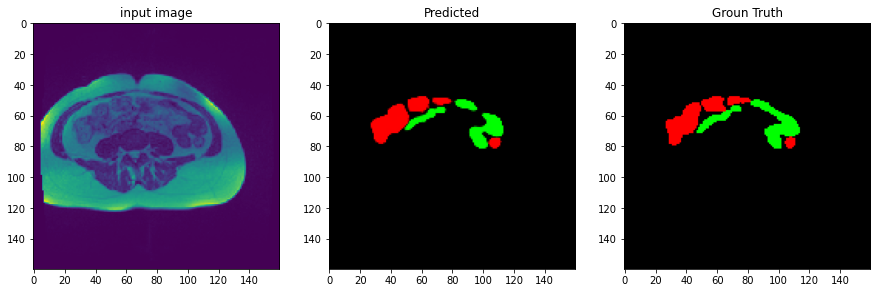

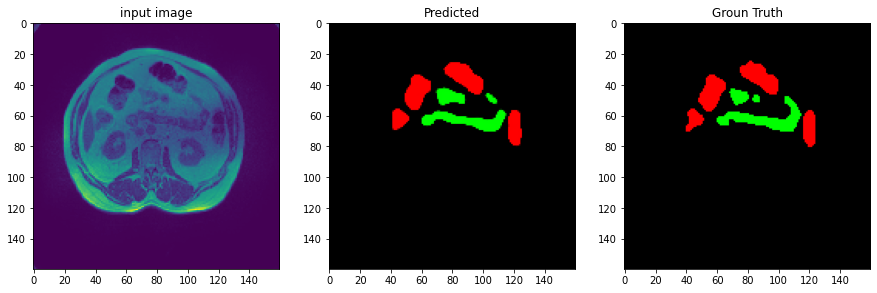

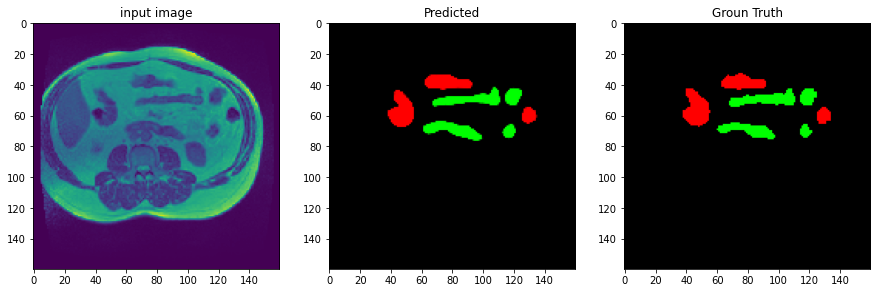

In [82]:
fid = 23

sub3(valrm[indices[fid]], pred_unet_plus[indices[fid]]   , valrb[indices[fid]] )
sub3(valrm[indices[fid+5]], pred_unet_plus[indices[fid+5]]   , valrb[indices[fid+5]] )
sub3(valrm[indices[fid+20]], pred_unet_plus[indices[fid+20]]   , valrb[indices[fid+20]] )

# Fariza_thesis

In [83]:
pred_fariza = frz_seg_model.predict(valrm, 16)

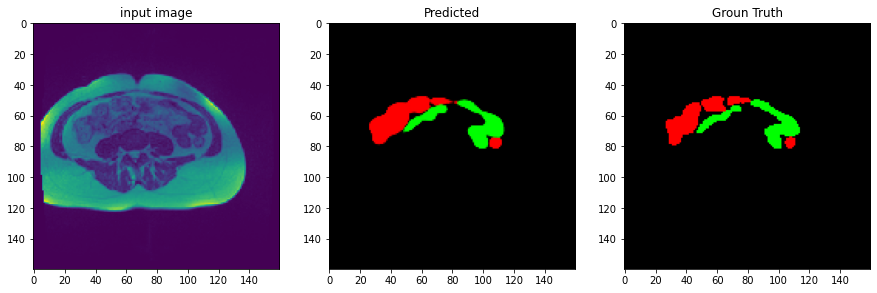

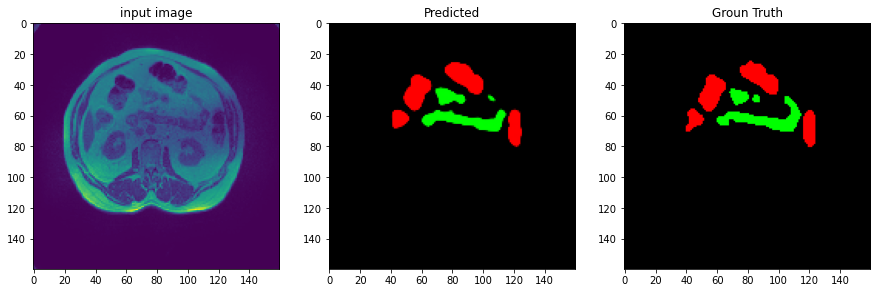

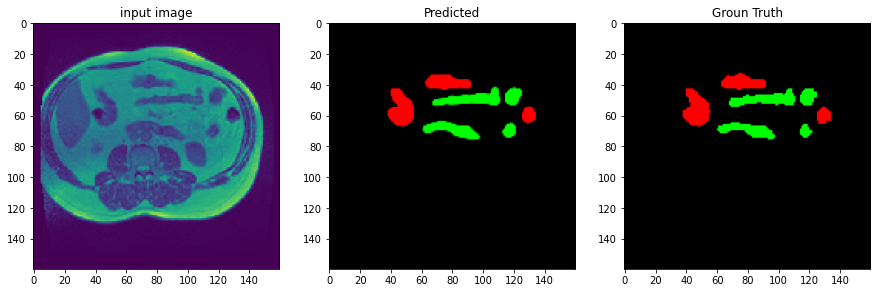

In [84]:
fid = 23

sub3(valrm[indices[fid]], pred_fariza[indices[fid]]   , valrb[indices[fid]] )
sub3(valrm[indices[fid+5]], pred_fariza[indices[fid+5]]   , valrb[indices[fid+5]] )
sub3(valrm[indices[fid+20]], pred_fariza[indices[fid+20]]   , valrb[indices[fid+20]] )

In [85]:
np.save('val_img', valrm)

In [86]:
np.save('val_lbl', valrb)